<a id="index"></a>

# Table of contents

* 1. [Data load](#data_load)
* 2. [Stadistical analysis](#stat)
  * 2.1. [Univariant analysis](#univariant)
    * 2.1.1. [Categorial variables](#cat_vars)
    *  2.1.2. [Numerical variables](#num_vars)
  * 2.2. [Multivariant analysis](#multivariant)
* 3. [Preprocessing](#preproc)
* 4. [Machine leraning models](#ml)
  * 4.1. [Prediction of PCR](#pcr_ml)
    * 4.1.1. [Support vector machine](#pcr_svm)
    * 4.1.2. [Decision tree](#pcr_decsiontree)
    * 4.1.3. [Random forest](#pcr_randomforest)
    * 4.1.4. [Gradient boosting Machines](#pcr_gbm)
  * 4.2. [Prediction of Status](#status_ml)
    * 4.2.1. [Support vector machine](#status_svm)
    * 4.2.2. [Decision tree](#status_decsiontree)
    * 4.2.3. [Random forest](#status_randomforest)
    * 4.2.4. [Gradient boosting Machines](#status_gbm)

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency as _chi2
from scipy import stats
import numpy as np
from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from imblearn import over_sampling
from sklearn.calibration import CalibratedClassifierCV
from sklearn import preprocessing


%matplotlib inline

<a id="data_load"></a>

## 1. Data load

[Back to contents](#index)

In [2]:
# Load data
file = './I-SPY 1 All Patient Clinical and Outcome Data.xlsx'
sheet_predictors = 'TCIA Patient Clinical Subset'
sheet_outcomes = 'TCIA Outcomes Subset'

# load and set index of predictors and drop Columns with metadata
predictors = pd.read_excel(file, sheet_name=sheet_predictors)
predictors = predictors.set_index('SUBJECTID')
predictors.drop(['DataExtractDt'],axis=1,inplace=True)

# load predictors and drop Columns with metadata
outcomes_df = pd.read_excel(file, sheet_name=sheet_outcomes)
outcomes_df.drop(['DataExtractDt'],axis=1,inplace=True)
outcomes_df = outcomes_df.set_index('SUBJECTID')

#merge outcomes and predictors using the Subject ID index
ISPY = predictors.join(outcomes_df)

#Rename columns
ISPY = ISPY.rename(columns={'ERpos':'ER+',
                        'PgRpos':'PR+',
                        'HR Pos':'HR+',
                        'Her2MostPos': 'HER2+',
                        'HR_HER2_CATEGORY': 'HR_HER2',
                        'BilateralCa':"Bilateral",
                        'sstat':'Survival',
                        'MRI LD Baseline':'MRI_LD_T1',
                        'MRI LD 1-3dAC':'MRI_LD_T2',
                        'MRI LD InterReg':'MRI_LD_T3',
                        'MRI LD PreSurg': 'MRI_LD_T4',
                        'survDtD2 (tx)':'Survival_length',
                        'rfs_ind':'RFS_code',
                        'RCBClass':'RCB'})

ISPY.head()

C:\Users\Usuario\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,age,race_id,ER+,PR+,HR+,HER2+,HR_HER2,HR_HER2_STATUS,Bilateral,Laterality,MRI_LD_T1,MRI_LD_T2,MRI_LD_T3,MRI_LD_T4,Survival,Survival_length,RFS,RFS_code,PCR,RCB
SUBJECTID,,,,,,,,,,,,,,,,,,,,
1001,38.73,1,1.0,0.0,1.0,0.0,1.0,HRposHER2neg,0,1,88.0,78.0,30.0,14.0,8,1264,751,1,0.0,2.0
1002,37.79,1,1.0,1.0,1.0,0.0,1.0,HRposHER2neg,0,2,29.0,26.0,66.0,16.0,8,1155,1043,1,0.0,3.0
1003,49.83,1,1.0,1.0,1.0,0.0,1.0,HRposHER2neg,0,1,50.0,64.0,54.0,46.0,7,2387,2387,0,0.0,3.0
1004,48.28,1,0.0,0.0,0.0,0.0,3.0,TripleNeg,0,1,91.0,90.0,99.0,43.0,7,2436,2436,0,0.0,NaN
1005,45.80,1,1.0,1.0,1.0,0.0,1.0,HRposHER2neg,0,1,98.0,109.0,60.0,42.0,7,2220,2520,0,0.0,NaN


In [3]:
# General information of data
ISPY.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 1001 to 1239
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              221 non-null    float64
 1   race_id          221 non-null    int64  
 2   ER+              219 non-null    float64
 3   PR+              219 non-null    float64
 4   HR+              219 non-null    float64
 5   HER2+            216 non-null    float64
 6   HR_HER2          216 non-null    float64
 7   HR_HER2_STATUS   216 non-null    object 
 8   Bilateral        221 non-null    int64  
 9   Laterality       221 non-null    int64  
 10  MRI_LD_T1        219 non-null    float64
 11  MRI_LD_T2        210 non-null    float64
 12  MRI_LD_T3        202 non-null    float64
 13  MRI_LD_T4        208 non-null    float64
 14  Survival         221 non-null    int64  
 15  Survival_length  221 non-null    int64  
 16  RFS              221 non-null    int64  
 17  RFS_code    

<a id="stat"></a>

## 2. Stadistical analysis

[Back to contents](#index)

<a id="univariant"></a>

### 2.1 Univariant analysis


[Back to contents](#index)

<a id="cat_vars"></a>

#### 2.1.1 Categorial variables

[Back to contents](#index)

Para el análisis estadístico se sustiruirán los valores de las variables categoricos.

In [4]:
df = ISPY.copy()

# Rename clinical outcomes and predictors 0/1 to make it easier to display
categorical_vars = ['ER+','PR+','HR+', 'HER2+', 'Bilateral','PCR']
for str_ in categorical_vars:
    df[str_] = df[str_].replace([1,0],['Yes','No'])
    
# rename other predictors and outcomes
df.Survival = df.Survival.replace([7,8,9], ['Yes','No','Lost'])
df.Laterality = df.Laterality.replace([1,2],['Left','Right'])
df.RFS_code = df.RFS_code.replace([0,1],['No','Yes'])
df.RCB = df.RCB.replace([0,1,2,3],['0','I', 'II', 'III'])
df['HR_HER2'] = df['HR_HER2'].replace([1,2,3],['HR+ Her2-', 'Her2+','Triple Negative'])
df.race_id = df.race_id.replace([1,3,4,5,6,50,0],['Caucasian', 'African American', 'Asian', 
                                                  'Native Hawaiian', 
                                                  'American Indian', 
                                                  'Multiple race', 'Unknown'])


df.head()

,age,race_id,ER+,PR+,HR+,HER2+,HR_HER2,HR_HER2_STATUS,Bilateral,Laterality,MRI_LD_T1,MRI_LD_T2,MRI_LD_T3,MRI_LD_T4,Survival,Survival_length,RFS,RFS_code,PCR,RCB
SUBJECTID,,,,,,,,,,,,,,,,,,,,
1001,38.73,Caucasian,Yes,No,Yes,No,HR+ Her2-,HRposHER2neg,No,Left,88.0,78.0,30.0,14.0,No,1264,751,Yes,No,II
1002,37.79,Caucasian,Yes,Yes,Yes,No,HR+ Her2-,HRposHER2neg,No,Right,29.0,26.0,66.0,16.0,No,1155,1043,Yes,No,III
1003,49.83,Caucasian,Yes,Yes,Yes,No,HR+ Her2-,HRposHER2neg,No,Left,50.0,64.0,54.0,46.0,Yes,2387,2387,No,No,III
1004,48.28,Caucasian,No,No,No,No,Triple Negative,TripleNeg,No,Left,91.0,90.0,99.0,43.0,Yes,2436,2436,No,No,NaN
1005,45.80,Caucasian,Yes,Yes,Yes,No,HR+ Her2-,HRposHER2neg,No,Left,98.0,109.0,60.0,42.0,Yes,2220,2520,No,No,NaN


In [5]:
# Summary for categorical data
df.describe(include='object')

,race_id,ER+,PR+,HR+,HER2+,HR_HER2,HR_HER2_STATUS,Bilateral,Laterality,Survival,RFS_code,PCR,RCB
count,221,219,219,219,216,216,216,221,221,221,221,215,201
unique,6,2,2,2,2,3,3,2,2,3,2,2,4
top,Caucasian,Yes,No,Yes,No,HR+ Her2-,HRposHER2neg,No,Right,Yes,No,No,II
freq,165,125,115,131,149,96,96,217,114,176,158,157,86


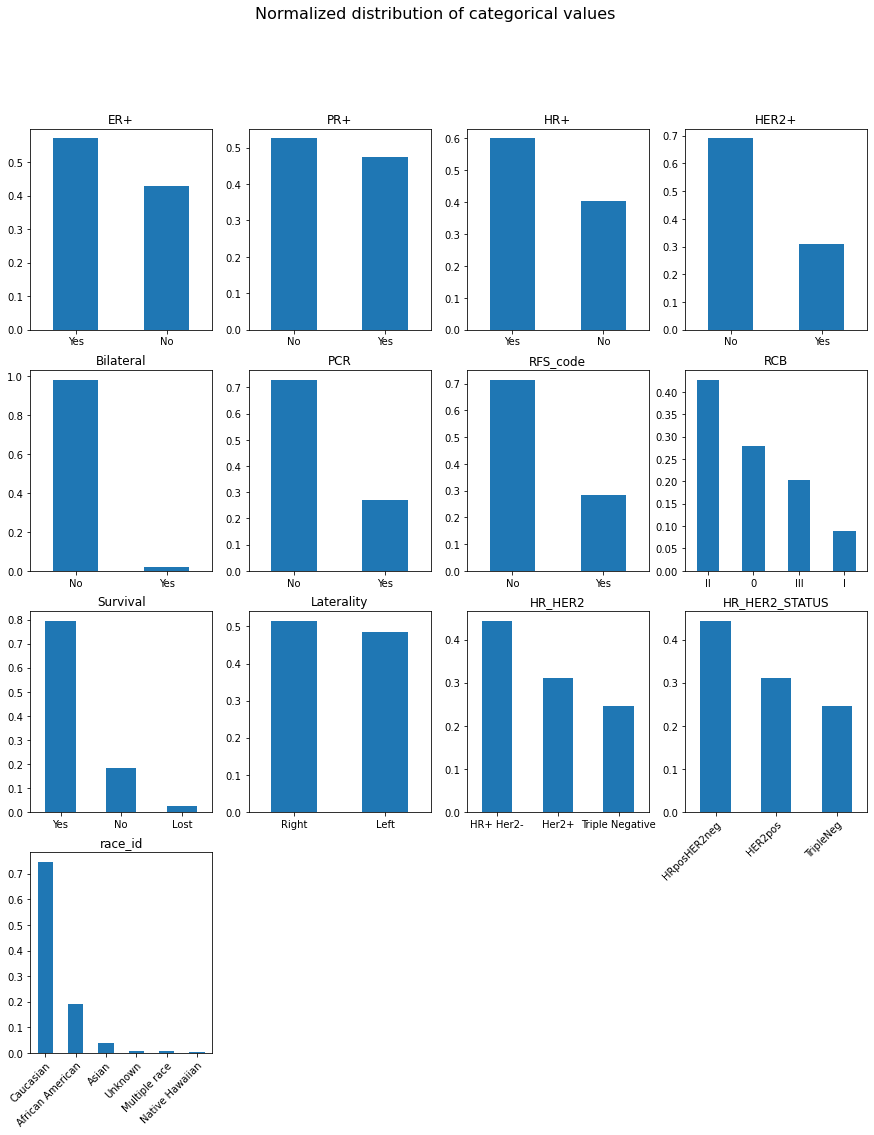

In [6]:
# Plots for categorical data
categorical_feats = categorical_vars + [ 'RFS_code', 'RCB', 'Survival', 'Laterality', 'HR_HER2', 'HR_HER2_STATUS', 'race_id']

fig, axs = plt.subplots(nrows=4, ncols=4)

for feat, ax in zip(categorical_feats, axs.ravel()):
    df[feat].value_counts(normalize = True).plot(kind='bar', ax=ax, title=feat, rot=0, figsize=(15,17))

axs[2,-1].set_xticklabels(axs[2,-1].get_xticklabels(),  rotation=45, ha='right', rotation_mode='anchor')
axs[3,0].set_xticklabels(axs[3,0].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    
for ax in axs[3,1:4]:
    ax.set_visible(False)
    
fig.suptitle('Normalized distribution of categorical values', fontsize=16)
plt.savefig('distribution_categorical_values.png')

Elminaremos la variable HR_HER2_STATUS por ser equivalente a la variable HR_HER2. Eliminaremos HR+ y HR_HER2 tambien por depender del resto de columnas

<a id="num_vars"></a>

#### 2.1.2 Numerical variables

[Back to contents](#index)

In [7]:
# Summary for numerical data
df.describe()

,age,MRI_LD_T1,MRI_LD_T2,MRI_LD_T3,MRI_LD_T4,Survival_length,RFS
count,221.000000,219.000000,210.000000,202.000000,208.000000,221.000000,221.000000
mean,48.250679,69.041096,61.204762,45.930693,29.865385,1403.859729,1312.556561
std,8.896377,30.948954,29.437485,29.875282,28.712655,520.398277,580.983447
min,26.690000,19.000000,9.000000,0.000000,0.000000,185.000000,179.000000
25%,42.080000,47.000000,38.000000,22.000000,4.000000,1126.000000,929.000000
50%,49.100000,68.000000,60.000000,42.500000,24.000000,1427.000000,1349.000000
75%,54.190000,88.000000,79.750000,61.750000,45.250000,1784.000000,1725.000000
max,68.820000,184.000000,156.000000,141.000000,129.000000,2468.000000,2520.000000


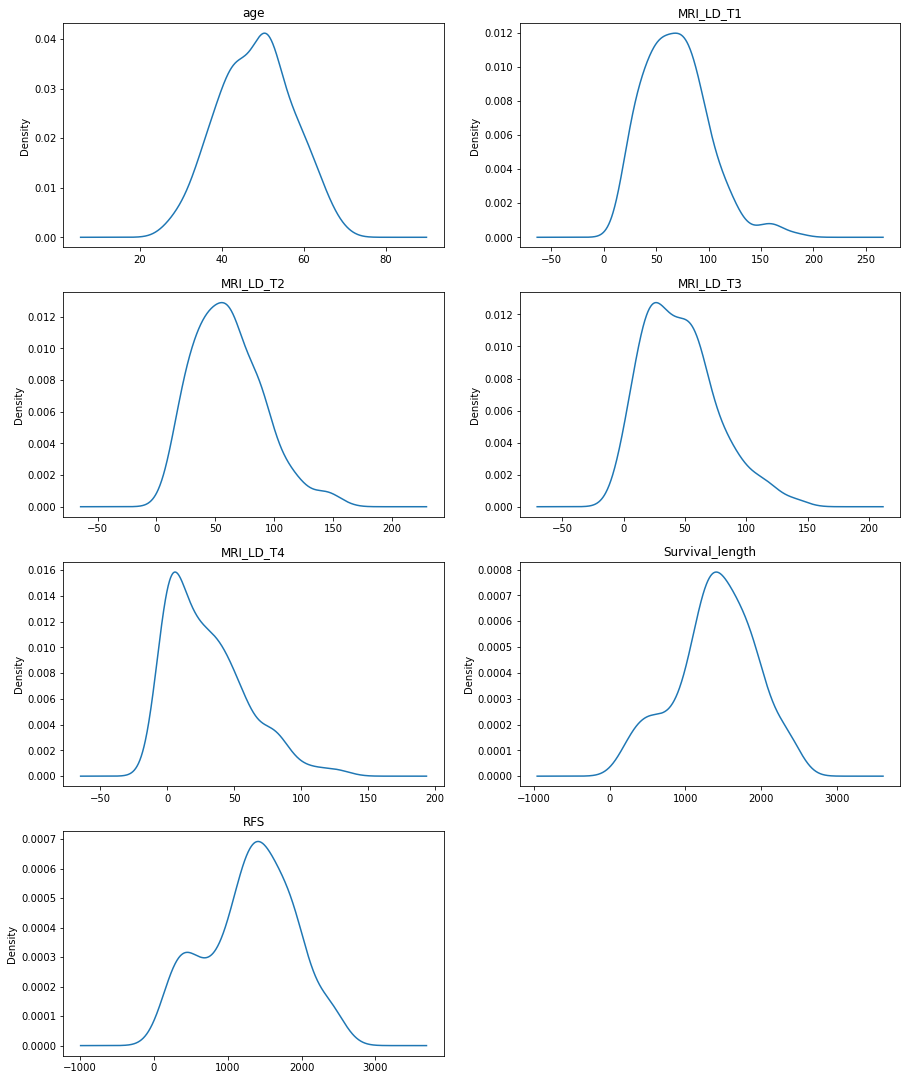

In [8]:
# Plots for numerical data
numeric_feats = [ 'age', 'MRI_LD_T1', 'MRI_LD_T2', 'MRI_LD_T3', 
                    'MRI_LD_T4', 'Survival_length', 'RFS']

fig, axs = plt.subplots(nrows=4, ncols=2)

for feat, ax in zip(numeric_feats, axs.ravel()):
    df[feat].plot(kind='density',  ax=ax, title=feat, figsize=(15,19))


axs[3, 1].set_visible(False)
plt.savefig('distribution_numerical_values.png')

<a id="multivariant"></a>

### 2.2 Multivariant analysis

[Back to contents](#index)

In [9]:
# Correlación en variables categoricas
def corr_categorical(predictors, output, data, alpha=0.05):
    
    df_chi = pd.DataFrame(np.zeros((len(predictors), 3)))
    df_chi = df_chi.set_index([predictors])
    df_chi.columns = ['chi_square', 'p-value', 'conclusion']
    
    vars_H1 = []
    
    fig = plt.figure()
    
    for i, var in enumerate(predictors):
        
        # create contingency table
        contigency = pd.crosstab(data[var], data[output], margins=True, margins_name="Total")
        
        # Calculation of Chisquare
        chi2, p , _, _= _chi2( contigency.values )
        
        # Conclusion
        conclusion = "Failed to reject the null hypothesis."
        if p <= alpha:
            conclusion = "Null Hypothesis is rejected."
            vars_H1.append(var)

        # Fill results dataframe
        df_chi.iloc[i, 0] = chi2
        df_chi.iloc[i, 1] = p
        df_chi.iloc[i, 2] = conclusion
        
    # Print plots of variables with null hypothesis rejected
    if len(vars_H1) == 7:
        r = 3
        fsize = (13,17) 
    else:
        r=1
        fsize = (10,5)
    
    fig, axs = plt.subplots(nrows=r, ncols=3, figsize=fsize)
    
    for var, ax in zip(vars_H1, axs.ravel()):
        
        contig = pd.crosstab(data[output], data[var])
        title = output + ' distribution'
        contig.plot(kind='bar',  ax=ax, stacked=True, rot=0, xlabel='', title=title)
    
    if len(vars_H1) == 7:
        for ax in axs[2,1:3]:
            ax.set_visible(False)
    
    plt.show()
    
    # 
    fname = output + '_distribution_corr_vars.png'
    plt.savefig(fname)
    
    return df_chi


<Figure size 432x288 with 0 Axes>

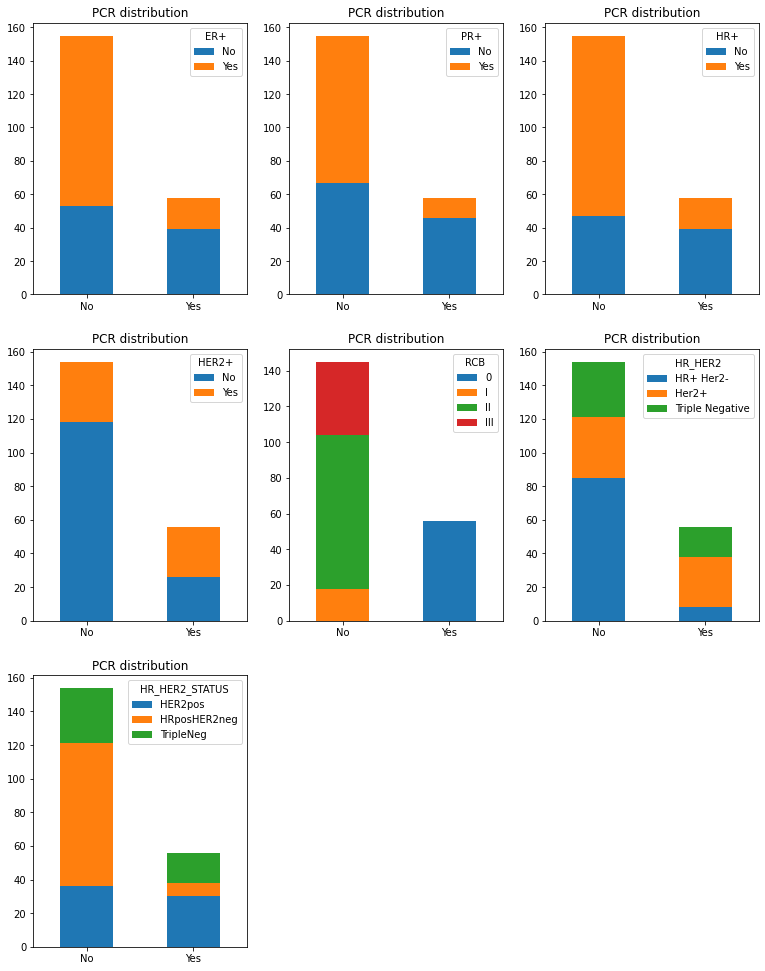

,chi_square,p-value,conclusion
ER+,18.786766,8.654911e-04,Null Hypothesis is rejected.
PR+,22.064961,1.945404e-04,Null Hypothesis is rejected.
HR+,23.896387,8.378662e-05,Null Hypothesis is rejected.
HER2+,17.373450,1.635235e-03,Null Hypothesis is rejected.
Bilateral,0.008085,9.999919e-01,Failed to reject the null hypothesis.
RFS_code,7.431104,1.147860e-01,Failed to reject the null hypothesis.
RCB,201.000000,3.933496e-39,Null Hypothesis is rejected.
Survival,6.353285,3.847998e-01,Failed to reject the null hypothesis.
Laterality,0.166042,9.967387e-01,Failed to reject the null hypothesis.
HR_HER2,29.373461,5.169281e-05,Null Hypothesis is rejected.


<Figure size 432x288 with 0 Axes>

In [10]:
# Correlacion con PCR  
categorical_predictors = [n for n in categorical_feats if n != 'PCR']
corr_categorical(categorical_predictors, 'PCR', df, alpha=0.05)

<Figure size 432x288 with 0 Axes>

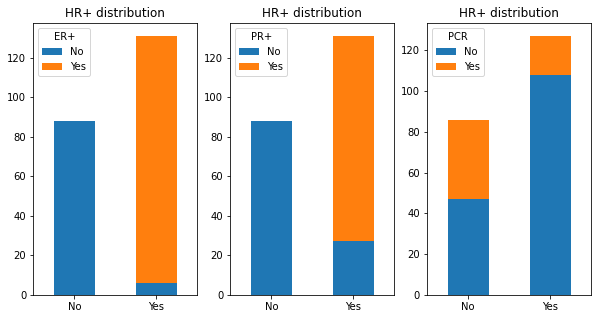

,chi_square,p-value,conclusion
ER+,195.630989,3.266597e-41,Null Hypothesis is rejected.
PR+,133.042682,8.701413e-28,Null Hypothesis is rejected.
HER2+,3.611206,4.611718e-01,Failed to reject the null hypothesis.
Bilateral,2.737014,6.027533e-01,Failed to reject the null hypothesis.
PCR,23.896387,8.378662e-05,Null Hypothesis is rejected.
RFS_code,1.563309,8.153710e-01,Failed to reject the null hypothesis.
RCB,21.344859,6.285623e-03,Null Hypothesis is rejected.
Survival,11.708236,6.880334e-02,Failed to reject the null hypothesis.
Laterality,0.026804,9.999110e-01,Failed to reject the null hypothesis.
HR_HER2,146.115035,5.125200e-29,Null Hypothesis is rejected.


<Figure size 432x288 with 0 Axes>

In [11]:
# Correlacion con HR
categorical_predictors = [n for n in categorical_feats if n != 'HR+']
corr_categorical(categorical_predictors, 'HR+', df, alpha=0.05)

<Figure size 432x288 with 0 Axes>

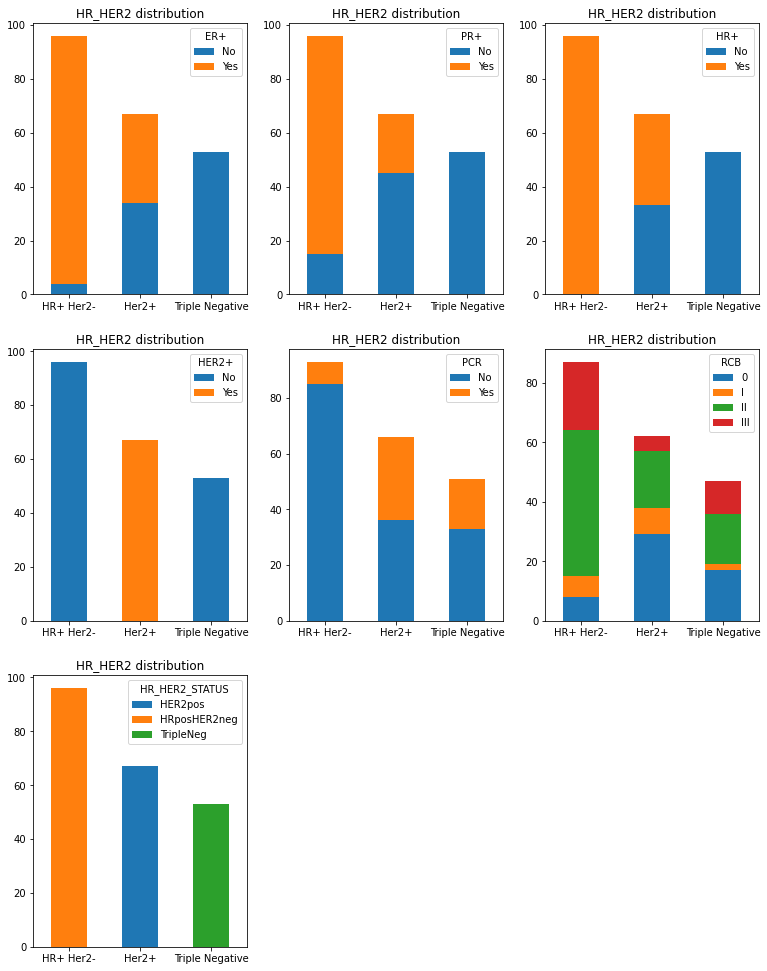

,chi_square,p-value,conclusion
ER+,131.590162,5.944506e-26,Null Hypothesis is rejected.
PR+,106.034829,1.377260e-20,Null Hypothesis is rejected.
HR+,146.115035,5.125200e-29,Null Hypothesis is rejected.
HER2+,216.000000,7.414050e-44,Null Hypothesis is rejected.
Bilateral,1.501690,9.593822e-01,Failed to reject the null hypothesis.
PCR,29.373461,5.169281e-05,Null Hypothesis is rejected.
RFS_code,5.275381,5.090093e-01,Failed to reject the null hypothesis.
RCB,36.272936,2.928286e-04,Null Hypothesis is rejected.
Survival,14.796329,9.668455e-02,Failed to reject the null hypothesis.
Laterality,0.095912,9.999823e-01,Failed to reject the null hypothesis.


<Figure size 432x288 with 0 Axes>

In [12]:
# Correlacion con HR_HER2
categorical_predictors = [n for n in categorical_feats if n != 'HR_HER2']
corr_categorical(categorical_predictors, 'HR_HER2', df, alpha=0.05)

<Figure size 432x288 with 0 Axes>

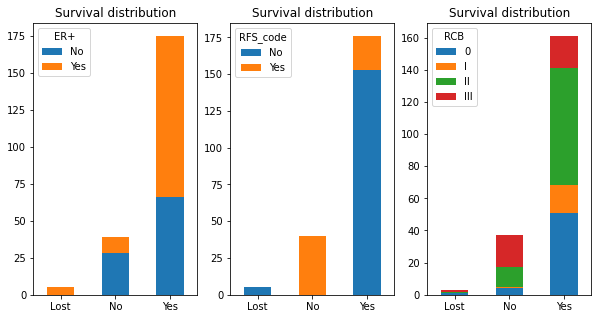

,chi_square,p-value,conclusion
ER+,18.967905,4.218181e-03,Null Hypothesis is rejected.
PR+,10.248289,1.145780e-01,Failed to reject the null hypothesis.
HR+,11.708236,6.880334e-02,Failed to reject the null hypothesis.
HER2+,2.302260,8.899084e-01,Failed to reject the null hypothesis.
Bilateral,1.041579,9.839869e-01,Failed to reject the null hypothesis.
PCR,6.353285,3.847998e-01,Failed to reject the null hypothesis.
RFS_code,122.894465,4.017110e-24,Null Hypothesis is rejected.
RCB,34.129653,6.435026e-04,Null Hypothesis is rejected.
Laterality,2.503519,8.680736e-01,Failed to reject the null hypothesis.
HR_HER2,14.796329,9.668455e-02,Failed to reject the null hypothesis.


<Figure size 432x288 with 0 Axes>

In [13]:
# Correlacion con Alive
categorical_predictors = [n for n in categorical_feats if n != 'Survival']
corr_categorical(categorical_predictors, 'Survival', df, alpha=0.05)

In [14]:
# Matriz de correlacion variables numéricas
corr_matrix = df.corr()
corr_matrix.style.background_gradient(axis=None, cmap='coolwarm')

,age,MRI_LD_T1,MRI_LD_T2,MRI_LD_T3,MRI_LD_T4,Survival_length,RFS
age,1.000000,-0.035066,-0.061463,-0.086164,0.027006,0.038192,0.066215
MRI_LD_T1,-0.035066,1.000000,0.873969,0.650825,0.429317,-0.005607,-0.061878
MRI_LD_T2,-0.061463,0.873969,1.000000,0.671798,0.421361,-0.017568,-0.063911
MRI_LD_T3,-0.086164,0.650825,0.671798,1.000000,0.667145,-0.104440,-0.159423
MRI_LD_T4,0.027006,0.429317,0.421361,0.667145,1.000000,-0.083064,-0.125068
Survival_length,0.038192,-0.005607,-0.017568,-0.104440,-0.083064,1.000000,0.868712
RFS,0.066215,-0.061878,-0.063911,-0.159423,-0.125068,0.868712,1.000000


In [15]:
# Relación categoricas y numericas

def plot_numeric_by_category(numeric_feats, categorical_feat):
    
    # Gráfico con los subplots
    fig, axs = plt.subplots(nrows=3, ncols=3)

    for feat, ax in zip(numeric_feats, axs.ravel()):

        for value in df[categorical_feat].unique():
            
            try:
                df.loc[df[categorical_feat]==value, feat].plot(kind='density', ax=ax, title=feat, figsize=(15,19))
            except ValueError: 
                pass            

        ax.legend(list(df[categorical_feat].unique()))

    axs[2, 1].set_visible(False)
    axs[2, -1].set_visible(False)
    title= 'Density distribution of numerical variables by ' + categorical_feat + ' categories'
    fig.suptitle(title, fontsize=16)
    
    fname = 'density_numerical_var_by' + categorical_feat + '.png'
    plt.savefig(fname)

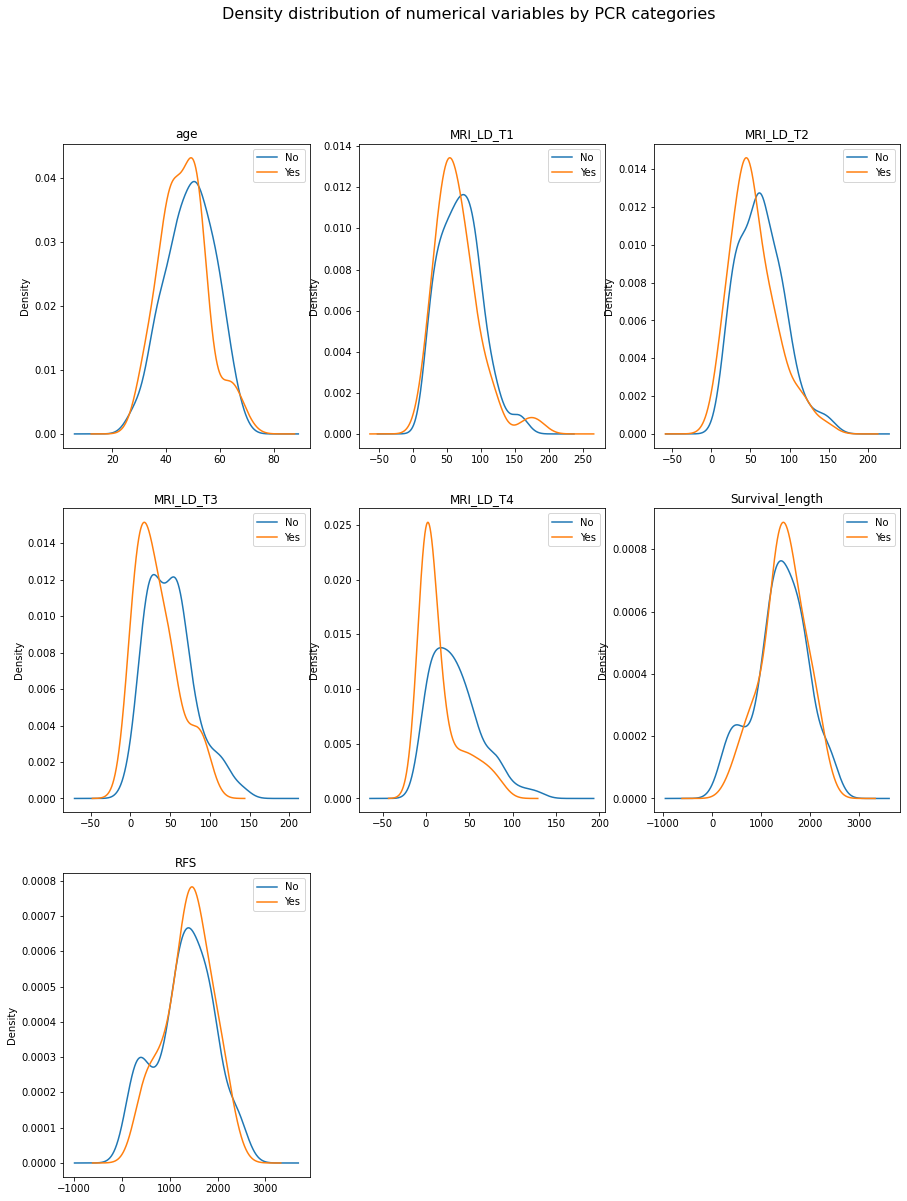

In [16]:
# By PCR
plot_numeric_by_category(numeric_feats, 'PCR')

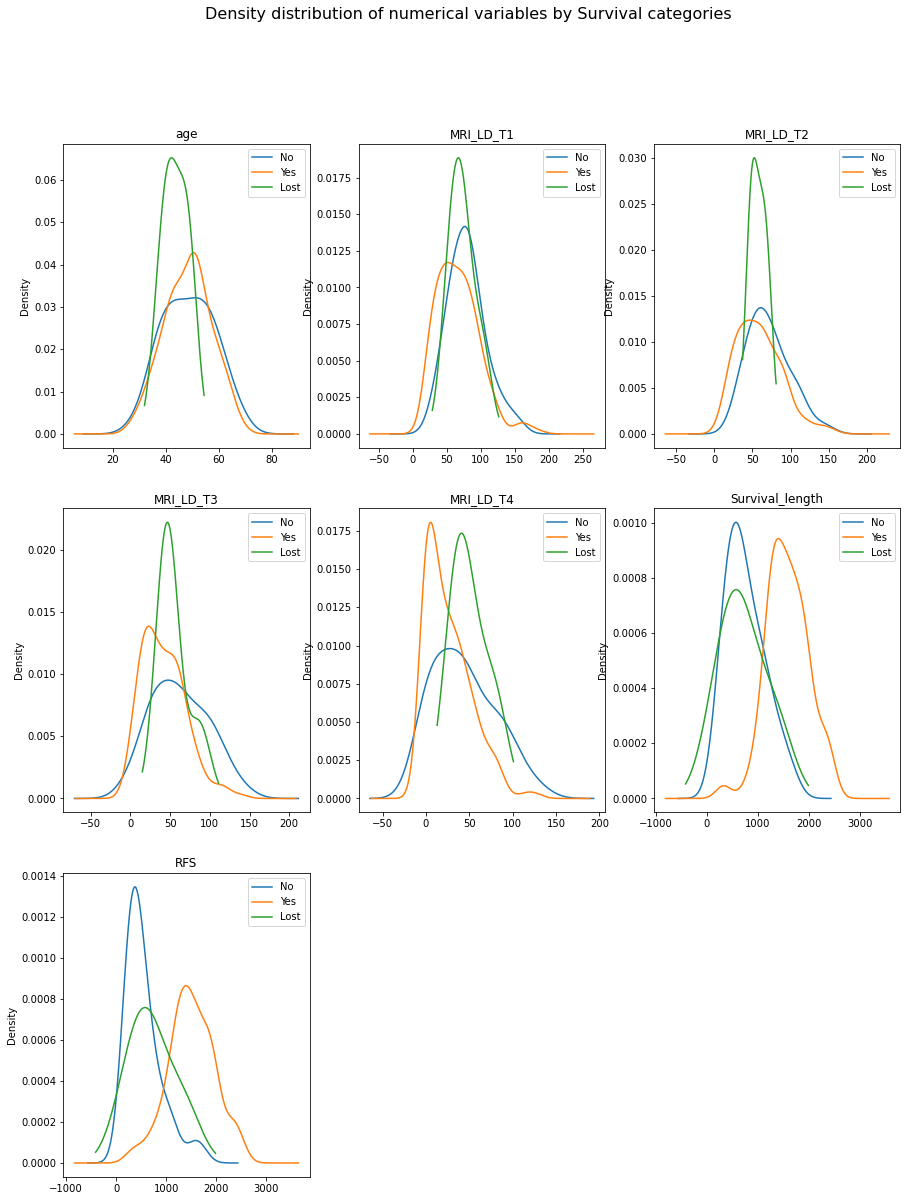

In [17]:
# By Alive
plot_numeric_by_category(numeric_feats, 'Survival')

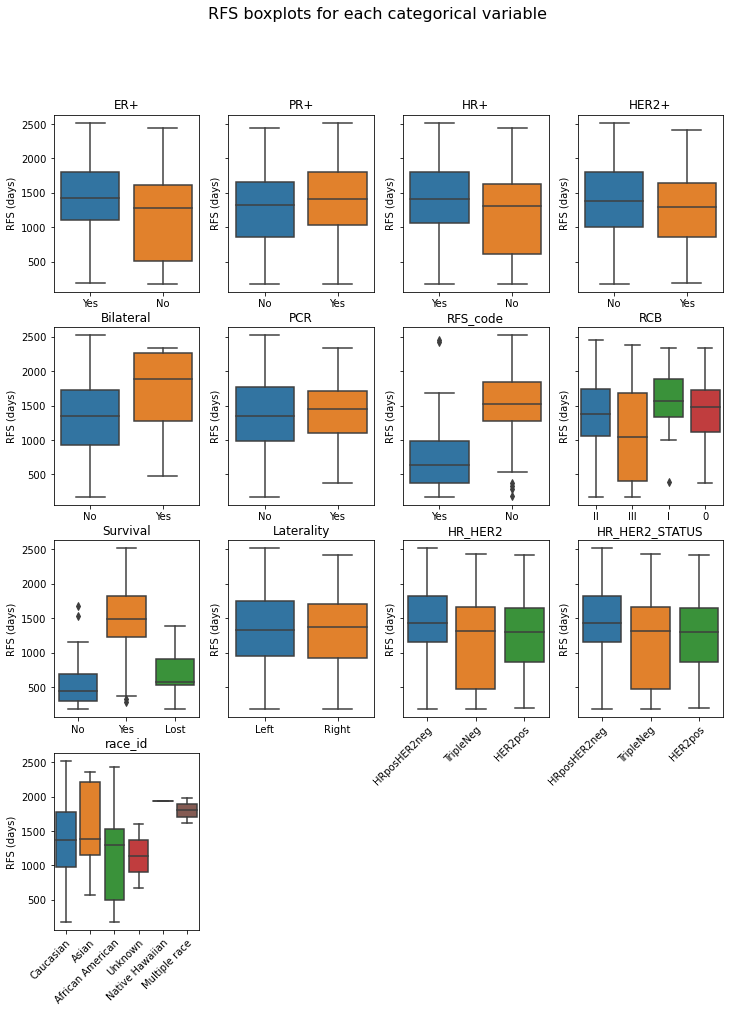

In [18]:
# Relación RFS y categoricas
fig, axs = plt.subplots(nrows=4, ncols=4, sharey=True, figsize=(12,15))

for feat, ax in zip(categorical_feats, axs.ravel()):

    sns.boxplot(ax=ax, x=feat, y='RFS', data=df).set(xlabel='', ylabel='RFS (days)', title=feat)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=0)

axs[2,2].set_xticklabels(axs[2,-1].get_xticklabels(),  rotation=45, ha='right', rotation_mode='anchor')
axs[2,3].set_xticklabels(axs[2,-1].get_xticklabels(),  rotation=45, ha='right', rotation_mode='anchor')
axs[3,0].set_xticklabels(axs[3,0].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    
for ax in axs[3,1:4]:
    ax.set_visible(False)
title= 'RFS boxplots for each categorical variable'
fig.suptitle(title, fontsize=16)
plt.savefig('rfs_boxplots.png')

<a id="preproc"></a>

## 3. Preprocessing

[Back to contents](#index)

In [19]:
ISPY = ISPY.loc[:, ~ISPY.columns.isin(['Survival_length', 'RCB', 'RFS_code', 'HR+', 'HR_HER2', 'HR_HER2_STATUS'])]
ISPY.head()

,age,race_id,ER+,PR+,HER2+,Bilateral,Laterality,MRI_LD_T1,MRI_LD_T2,MRI_LD_T3,MRI_LD_T4,Survival,RFS,PCR
SUBJECTID,,,,,,,,,,,,,,
1001,38.73,1,1.0,0.0,0.0,0,1,88.0,78.0,30.0,14.0,8,751,0.0
1002,37.79,1,1.0,1.0,0.0,0,2,29.0,26.0,66.0,16.0,8,1043,0.0
1003,49.83,1,1.0,1.0,0.0,0,1,50.0,64.0,54.0,46.0,7,2387,0.0
1004,48.28,1,0.0,0.0,0.0,0,1,91.0,90.0,99.0,43.0,7,2436,0.0
1005,45.80,1,1.0,1.0,0.0,0,1,98.0,109.0,60.0,42.0,7,2520,0.0


In [20]:
print("Number of missing values per column: \n{}".format(ISPY.isnull().sum())) # None

# Remove missing values
ISPY = ISPY.loc[ISPY.Survival != 9,:] #Lost values
ISPY.dropna(inplace=True)

Number of missing values per column: 
age            0
race_id        0
ER+            2
PR+            2
HER2+          5
Bilateral      0
Laterality     0
MRI_LD_T1      2
MRI_LD_T2     11
MRI_LD_T3     19
MRI_LD_T4     13
Survival       0
RFS            0
PCR            6
dtype: int64


In [21]:
# Save clean dataset 
ISPY.to_csv('ISPY_clean.csv', index=False)

In [22]:
# Normalize data
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
ISPY_norm = scaler.fit_transform(ISPY)
ISPY_norm_df = pd.DataFrame(ISPY_norm, columns=ISPY.columns)
ISPY_norm_df.head()

,age,race_id,ER+,PR+,HER2+,Bilateral,Laterality,MRI_LD_T1,MRI_LD_T2,MRI_LD_T3,MRI_LD_T4,Survival,RFS,PCR
0,0.285782,0.02,1.0,0.0,0.0,0.0,0.0,0.418182,0.469388,0.212766,0.111111,1.0,0.244340,0.0
1,0.263470,0.02,1.0,1.0,0.0,0.0,1.0,0.060606,0.115646,0.468085,0.126984,1.0,0.369073,0.0
2,0.549252,0.02,1.0,1.0,0.0,0.0,0.0,0.187879,0.374150,0.382979,0.365079,0.0,0.943187,0.0
3,0.512461,0.02,0.0,0.0,0.0,0.0,0.0,0.436364,0.551020,0.702128,0.341270,0.0,0.964118,0.0
4,0.453596,0.02,1.0,1.0,0.0,0.0,0.0,0.478788,0.680272,0.425532,0.333333,0.0,1.000000,0.0


<a id="ml"></a>

## 4. Machine learning models

[Back to contents](#index)

In [23]:
RANDOM_STATE = 42; # for reproducibility

In [24]:
def split_data(Xdata,Ydata):
        
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata,
                                                        test_size=0.33, 
                                                        stratify=Ydata,
                                                        random_state=RANDOM_STATE)
        
    return X_train, X_test, y_train, y_test



def binary_classifier_metrics(classifier, Xtrain, Ytrain, Xtest, Ytest, classes, outcome):
    # metrics
    predicted_class = classifier.predict(Xtest)

    auc = metrics.roc_auc_score(Ytest,predicted_class)
    auc = np.round(auc,3)


    # ROC curve
    probability = classifier.predict_proba(Xtest)
    fpr, tpr, _  = metrics.roc_curve(Ytest, probability[:,1], drop_intermediate=False)

    # report
    print(metrics.classification_report(Ytest, predicted_class, target_names=classes))
    print('The estimated AUC is ' + str(auc))
    print('\n'*2)
    
    #Confusion matrix
    conf_matrix = confusion_matrix(Ytest, predicted_class)
    fig,axis = plt.subplots(figsize=(5, 4))
    sns.heatmap(conf_matrix, cmap="Blues" ,annot=True, fmt= '.0f',ax=axis)
    axis.set_title("Confusion matrix")
    axis.set_xlabel('Predicted')
    axis.set_xticklabels(classes)
    axis.set_ylabel('Real')
    axis.set_yticklabels(classes)
    conf_matrix

    return auc, fpr, tpr

def plot_roc(fpr1_, tpr1_, auc1_, title =''):
    
    plt.figure()
    plt.plot(fpr1_, tpr1_);
    plt.legend(['AUC = ' + str(auc1_)]);
    plt.xlabel('False-positive rate');
    plt.ylabel('True-positive rate');
    plt.title(title);
    
    
def plot_feature_importance(clf_name, classifier, predictors):
    
    # Feature importance
    fig,axis = plt.subplots(figsize=(5, 4))
    
    if clf_name == 'SUPPORT VECTOR MACHINE CLASSIFIER':
        feat_imp = pd.Series(abs(classifier.coef_[0]), index=predictors).nlargest(10).sort_values(ascending=False)
    else:
        feat_imp = pd.Series(classifier.feature_importances_, predictors).sort_values(ascending=False)
    
    feat_imp.plot(kind='barh', title='Feature Importances')
    plt.xlabel('Feature Importance Score')


def train_test_classifier(Xdata, Ydata, clf, clf_name, pars, score, outcome, classes = ['NO', 'YES'], cv=3):
    
    # split data
    X_train, X_test, y_train, y_test = split_data(Xdata,Ydata)

    # perform grid search
    grid=  GridSearchCV(clf, param_grid = pars, scoring = score, cv= cv, verbose = 0, n_jobs = -1)

    # fit
    grid.fit(X_train,y_train)
    
    
    # Print best params of model
    print('=='*30)
    print(clf_name + ' predicting ' + outcome)
    print('=='*30)   
    print('Best parameters: ')
    print(grid.best_params_)
    print('--'*30 + '\n')

    
    # metrics
    auc, fpr, tpr = binary_classifier_metrics(grid.best_estimator_, X_train, y_train, 
                                              X_test, y_test, classes, outcome)
    
    # Plot roc curve
    plot_roc(fpr, tpr, auc, title='ROC curve')
    
    # Plot feat importance
    plot_feature_importance(clf_name, grid.best_estimator_, X_test.keys())
    
    # output
    return auc, fpr, tpr, grid.best_estimator_


<a id="pcr_ml"></a>

### 4.1. Prediction of PCR

[Back to contents](#index)

In [25]:
# Drop columns that represent other clinical outcomes
df_pcr = ISPY_norm_df.drop(['Survival', 'RFS'], axis=1)

x= df_pcr.drop(['PCR'], axis=1)
y = df_pcr['PCR']

<a id="pcr_svm"></a>

#### 4.1.1 Support vector machine

[Back to contents](#index)

SUPPORT VECTOR MACHINE CLASSIFIER predicting PCR
Best parameters: 
{'C': 1, 'gamma': 0.01, 'kernel': 'linear'}
------------------------------------------------------------

              precision    recall  f1-score   support

          NO       0.78      0.95      0.86        44
         YES       0.60      0.20      0.30        15

    accuracy                           0.76        59
   macro avg       0.69      0.58      0.58        59
weighted avg       0.73      0.76      0.72        59

The estimated AUC is 0.577





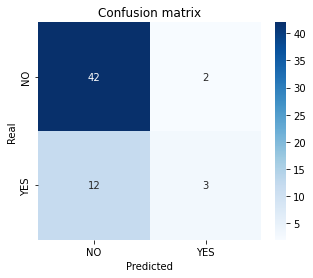

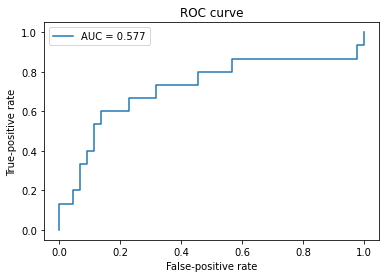

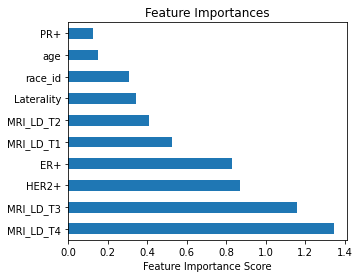

In [26]:
######################## SUPPORT VECTOR MACHINE ########################
# Define classifier
clf = svm.SVC(random_state=RANDOM_STATE, probability=True)
clf_name = 'SUPPORT VECTOR MACHINE CLASSIFIER'

# define parameter grid search
pars = dict(C = [0.1, 1, 5, 10],
            gamma = [1e-2, .1, 1, 10],
            kernel = ['linear', 'poly', 'rbf'])

# define scoring metric
score = 'accuracy'

# Variable to predict
outcome = 'PCR'

# train and validate classifier
auc1, fpr1, tpr1, svm_pcr = train_test_classifier(x, y, clf, clf_name, pars, score, outcome)

<a id="pcr_decsiontree"></a>

#### 4.1.2 Decision tree

[Back to contents](#index)

DECISION TREE CLASSIFIER predicting PCR
Best parameters: 
{'max_depth': 7, 'min_samples_split': 6}
------------------------------------------------------------

              precision    recall  f1-score   support

          NO       0.83      0.89      0.86        44
         YES       0.58      0.47      0.52        15

    accuracy                           0.78        59
   macro avg       0.71      0.68      0.69        59
weighted avg       0.77      0.78      0.77        59

The estimated AUC is 0.677





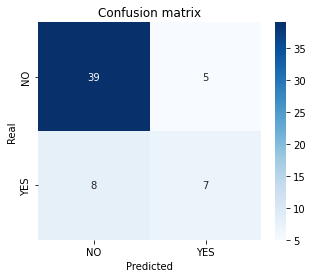

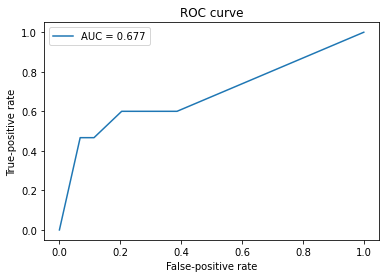

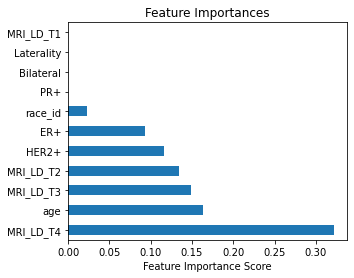

In [27]:
######################## TREE DECISION ########################
# Define classifier
clf = DecisionTreeClassifier(random_state=RANDOM_STATE)
clf_name = 'DECISION TREE CLASSIFIER'

# define parameter grid search
pars = dict(max_depth = range(5,16,2),
            min_samples_split = range(2, 11, 2))

# define scoring metric
score = 'accuracy'

# Variable to predict
outcome = 'PCR'

# train and validate classifier
auc1, fpr1, tpr1, dt_pcr = train_test_classifier(x, y, clf, clf_name, pars, score, outcome)

<a id="pcr_randomforest"></a>

#### 4.1.3 Random forest

[Back to contents](#index)

RANDOM FOREST CLASSIFIER predicting PCR
Best parameters: 
{'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 10}
------------------------------------------------------------

              precision    recall  f1-score   support

          NO       0.80      0.93      0.86        44
         YES       0.62      0.33      0.43        15

    accuracy                           0.78        59
   macro avg       0.71      0.63      0.65        59
weighted avg       0.76      0.78      0.75        59

The estimated AUC is 0.633





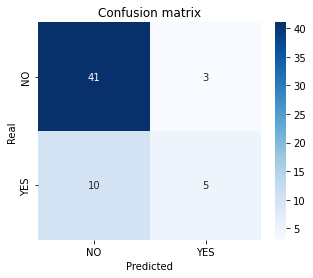

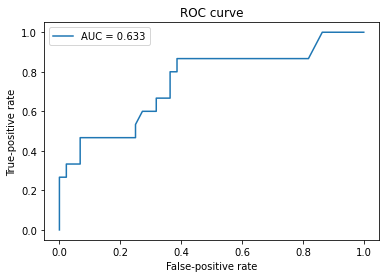

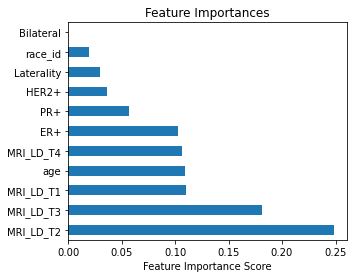

In [28]:
######################## RANDOM FOREST ########################
# Define classifier
clf = RandomForestClassifier(random_state=RANDOM_STATE)
clf_name = 'RANDOM FOREST CLASSIFIER'

# define parameter grid search
pars = dict(min_samples_split = range(2, 11, 2),
            n_estimators = [10, 50, 100, 150],
            max_depth = range(5,16,2))

# define scoring metric
score = 'accuracy'

# Variable to predict
outcome = 'PCR'

# train and validate classifier
auc1, fpr1, tpr1, rf_pcr = train_test_classifier(x, y, clf, clf_name, pars, score, outcome)

<a id="pcr_gbm"></a>

#### 4.1.4. Gradient Boosting Machine

[Back to contents](#index)

GRADIENT BOOSTING MACHINES predicting PCR
Best parameters: 
{'learning_rate': 0.1, 'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 150}
------------------------------------------------------------

              precision    recall  f1-score   support

          NO       0.81      0.89      0.85        44
         YES       0.55      0.40      0.46        15

    accuracy                           0.76        59
   macro avg       0.68      0.64      0.65        59
weighted avg       0.74      0.76      0.75        59

The estimated AUC is 0.643





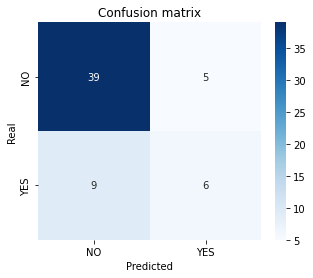

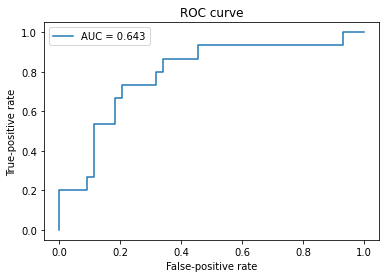

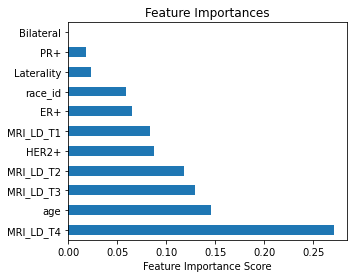

In [29]:
######################## GRADIENT BOOSTING MACHINES ########################
# Define classifier
clf = GradientBoostingClassifier(random_state=RANDOM_STATE)
clf_name = 'GRADIENT BOOSTING MACHINES'

# define parameter grid search
pars = dict(learning_rate = [0.1, 0.05, 0.01, 0.001],
            n_estimators = [10, 50, 100, 150],
            max_depth = range(5,16,2), 
            min_samples_split = range(2, 11, 2))

# define scoring metric
score = 'roc_auc'

# Variable to predict
outcome = 'PCR'

# train and validate classifier
auc1, fpr1, tpr1, gbm_pcr = train_test_classifier(x, y, clf, clf_name, pars, score, outcome)

<a id="status_ml"></a>

### 4.2. Prediction of Survival Status

[Back to contents](#index)

In [30]:
# Drop columns that represent other clinical outcomes
df_survival = ISPY_norm_df.drop(['PCR', 'RFS'], axis=1)
df_survival.Survival = df_survival.Survival.replace([7,8], [1,0])


x= df_survival.drop(['Survival'], axis=1)
y = df_survival['Survival']

<a id="status_svm"></a>

#### 4.2.1. Support Vector Machine

[Back to contents](#index)

SUPPORT VECTOR MACHINE CLASSIFIER predicting Survival
Best parameters: 
{'C': 1, 'gamma': 0.01, 'kernel': 'linear'}
------------------------------------------------------------

              precision    recall  f1-score   support

         YES       0.81      1.00      0.90        48
          NO       0.00      0.00      0.00        11

    accuracy                           0.81        59
   macro avg       0.41      0.50      0.45        59
weighted avg       0.66      0.81      0.73        59

The estimated AUC is 0.5





C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


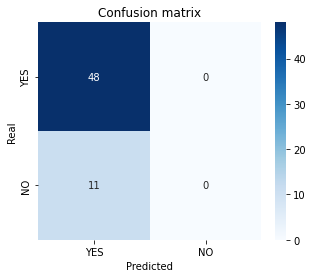

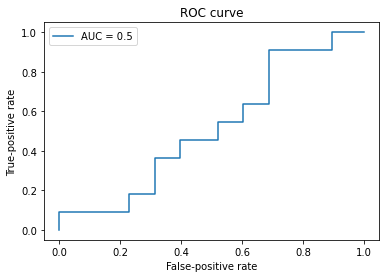

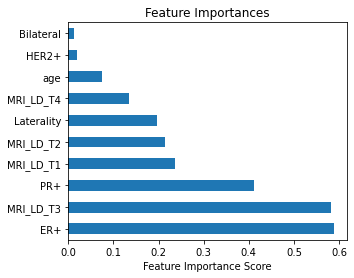

In [31]:
######################## SUPPORT VECTOR MACHINE ########################
# Define classifier
clf = svm.SVC(random_state=RANDOM_STATE, probability=True)
clf_name = 'SUPPORT VECTOR MACHINE CLASSIFIER'

# define parameter grid search
pars = dict(C = [0.1, 1, 5, 10],
            gamma = [1e-2, .1, 1, 10],
            kernel = ['linear', 'poly', 'rbf'])

# define scoring metric
score = 'accuracy'

# Variable to predict
outcome = 'Survival'

# train and validate classifier
classes = ['YES', 'NO']
auc1, fpr1, tpr1, svm_ss = train_test_classifier(x, y, clf, clf_name, pars, score, outcome, classes)

<a id="status_decsiontree"></a>

#### 4.2.2. Decision tree

[Back to contents](#index)

DECISION TREE CLASSIFIER predicting Survival
Best parameters: 
{'max_depth': 7, 'min_samples_split': 2}
------------------------------------------------------------

              precision    recall  f1-score   support

         YES       0.80      0.90      0.84        48
          NO       0.00      0.00      0.00        11

    accuracy                           0.73        59
   macro avg       0.40      0.45      0.42        59
weighted avg       0.65      0.73      0.69        59

The estimated AUC is 0.448





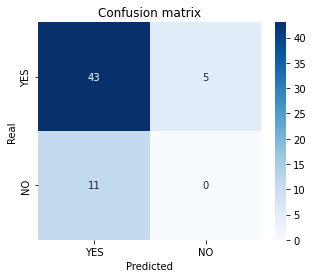

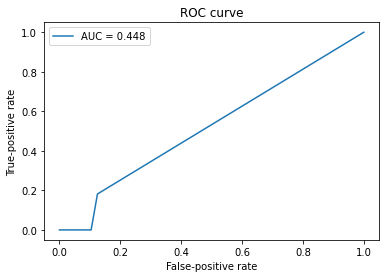

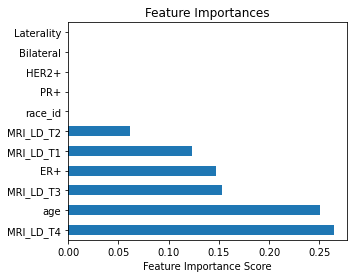

In [32]:
######################## TREE DECISION ########################
# Define classifier
clf = DecisionTreeClassifier(random_state=RANDOM_STATE)
clf_name = 'DECISION TREE CLASSIFIER'

# define parameter grid search
pars = dict(max_depth = range(5,16,2),
            min_samples_split = range(2, 11, 2))

# define scoring metric
score = 'accuracy'

# Variable to predict
outcome = 'Survival'

# train and validate classifier
classes = ['YES', 'NO']
auc1, fpr1, tpr1, dt_ss = train_test_classifier(x, y, clf, clf_name, pars, score, outcome, classes)

<a id="status_randomforest"></a>

#### 4.2.3. Random forest

[Back to contents](#index)

RANDOM FOREST CLASSIFIER predicting Survival
Best parameters: 
{'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 10}
------------------------------------------------------------

              precision    recall  f1-score   support

         YES       0.84      1.00      0.91        48
          NO       1.00      0.18      0.31        11

    accuracy                           0.85        59
   macro avg       0.92      0.59      0.61        59
weighted avg       0.87      0.85      0.80        59

The estimated AUC is 0.591





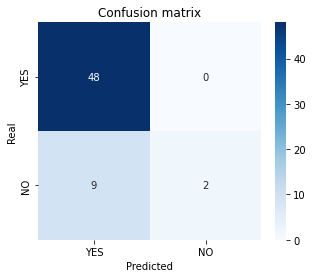

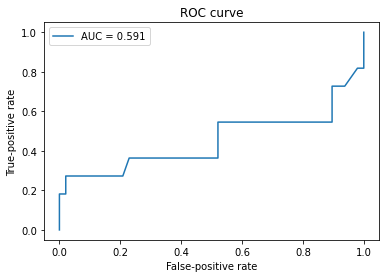

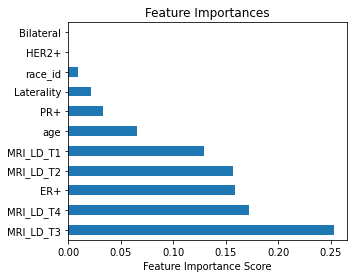

In [33]:
######################## RANDOM FOREST ########################
# Define classifier
clf = RandomForestClassifier(random_state=RANDOM_STATE)
clf_name = 'RANDOM FOREST CLASSIFIER'

# define parameter grid search
pars = dict(min_samples_split = range(2, 11, 2),
            n_estimators = [10, 50, 100, 150],
            max_depth = range(5,16,2))

# define scoring metric
score = 'accuracy'

# Variable to predict
outcome = 'Survival'

# train and validate classifier
classes = ['YES', 'NO']
auc1, fpr1, tpr1, rf_ss = train_test_classifier(x, y, clf, clf_name, pars, score, outcome, classes)

<a id="status_gbm"></a>

#### 4.2.4. Gradient Boosting Machine

[Back to contents](#index)

GRADIENT BOOSTING MACHINES predicting Survival
Best parameters: 
{'learning_rate': 0.1, 'max_depth': 9, 'min_samples_split': 8, 'n_estimators': 100}
------------------------------------------------------------

              precision    recall  f1-score   support

         YES       0.81      0.90      0.85        48
          NO       0.17      0.09      0.12        11

    accuracy                           0.75        59
   macro avg       0.49      0.49      0.48        59
weighted avg       0.69      0.75      0.71        59

The estimated AUC is 0.493





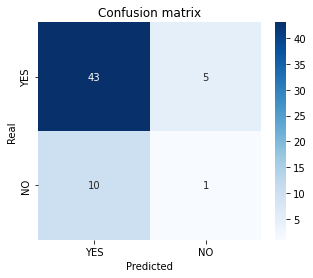

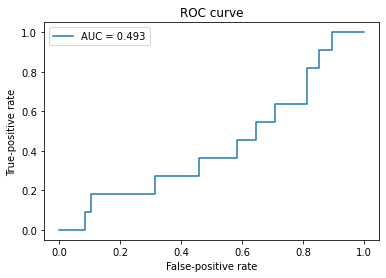

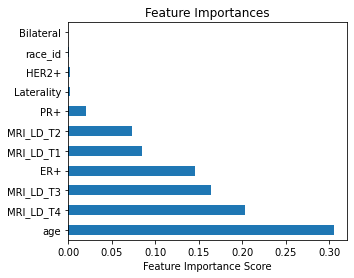

In [34]:
######################## GRADIENT BOOSTING MACHINES ########################
# Define classifier
clf = GradientBoostingClassifier(random_state=RANDOM_STATE)
clf_name = 'GRADIENT BOOSTING MACHINES'

# define parameter grid search
pars = dict(learning_rate = [0.1, 0.05, 0.01, 0.001],
            n_estimators = [10, 50, 100, 150],
            max_depth = range(5,16,2), 
            min_samples_split = range(2, 11, 2))

# define scoring metric
score = 'roc_auc'

# Variable to predict
outcome = 'Survival'

# train and validate classifier
classes = ['YES', 'NO']
auc1, fpr1, tpr1, gbm_ss = train_test_classifier(x, y, clf, clf_name, pars, score, outcome, classes)

[Back to contents](#index)

### Save models

In [35]:
import pickle

# Save models
# Predicting SS
pickle.dump(gbm_ss, open('gbm_ss.sav', 'wb'))
pickle.dump(rf_ss, open('rf_ss.sav', 'wb'))
pickle.dump(dt_ss, open('dt_ss.sav', 'wb'))
pickle.dump(svm_ss, open('svm_ss.sav', 'wb'))

# Predicting PCR
pickle.dump(gbm_pcr, open('gbm_pcr.sav', 'wb'))
pickle.dump(rf_pcr, open('rf_pcr.sav', 'wb'))
pickle.dump(dt_pcr, open('dt_pcr.sav', 'wb'))
pickle.dump(svm_pcr, open('svm_pcr.sav', 'wb'))